In [1]:
# ----------------- #
# Suppress Warnings #
# ----------------- #

import warnings
warnings.simplefilter("ignore") 

from keras.models import model_from_json
import joblib
import numpy as np
import sys
from os.path import abspath
if abspath('../../utils') not in sys.path:
    sys.path.append(abspath('../../utils'))
from utils import ventana
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
np.random.seed(99)

Using TensorFlow backend.


In [2]:
SITENAME = 'Tuolumne'
FEATURES = ['dem', 'vegh', 'slope', 'aspect', 'curvature']
ARCH = 'grande'

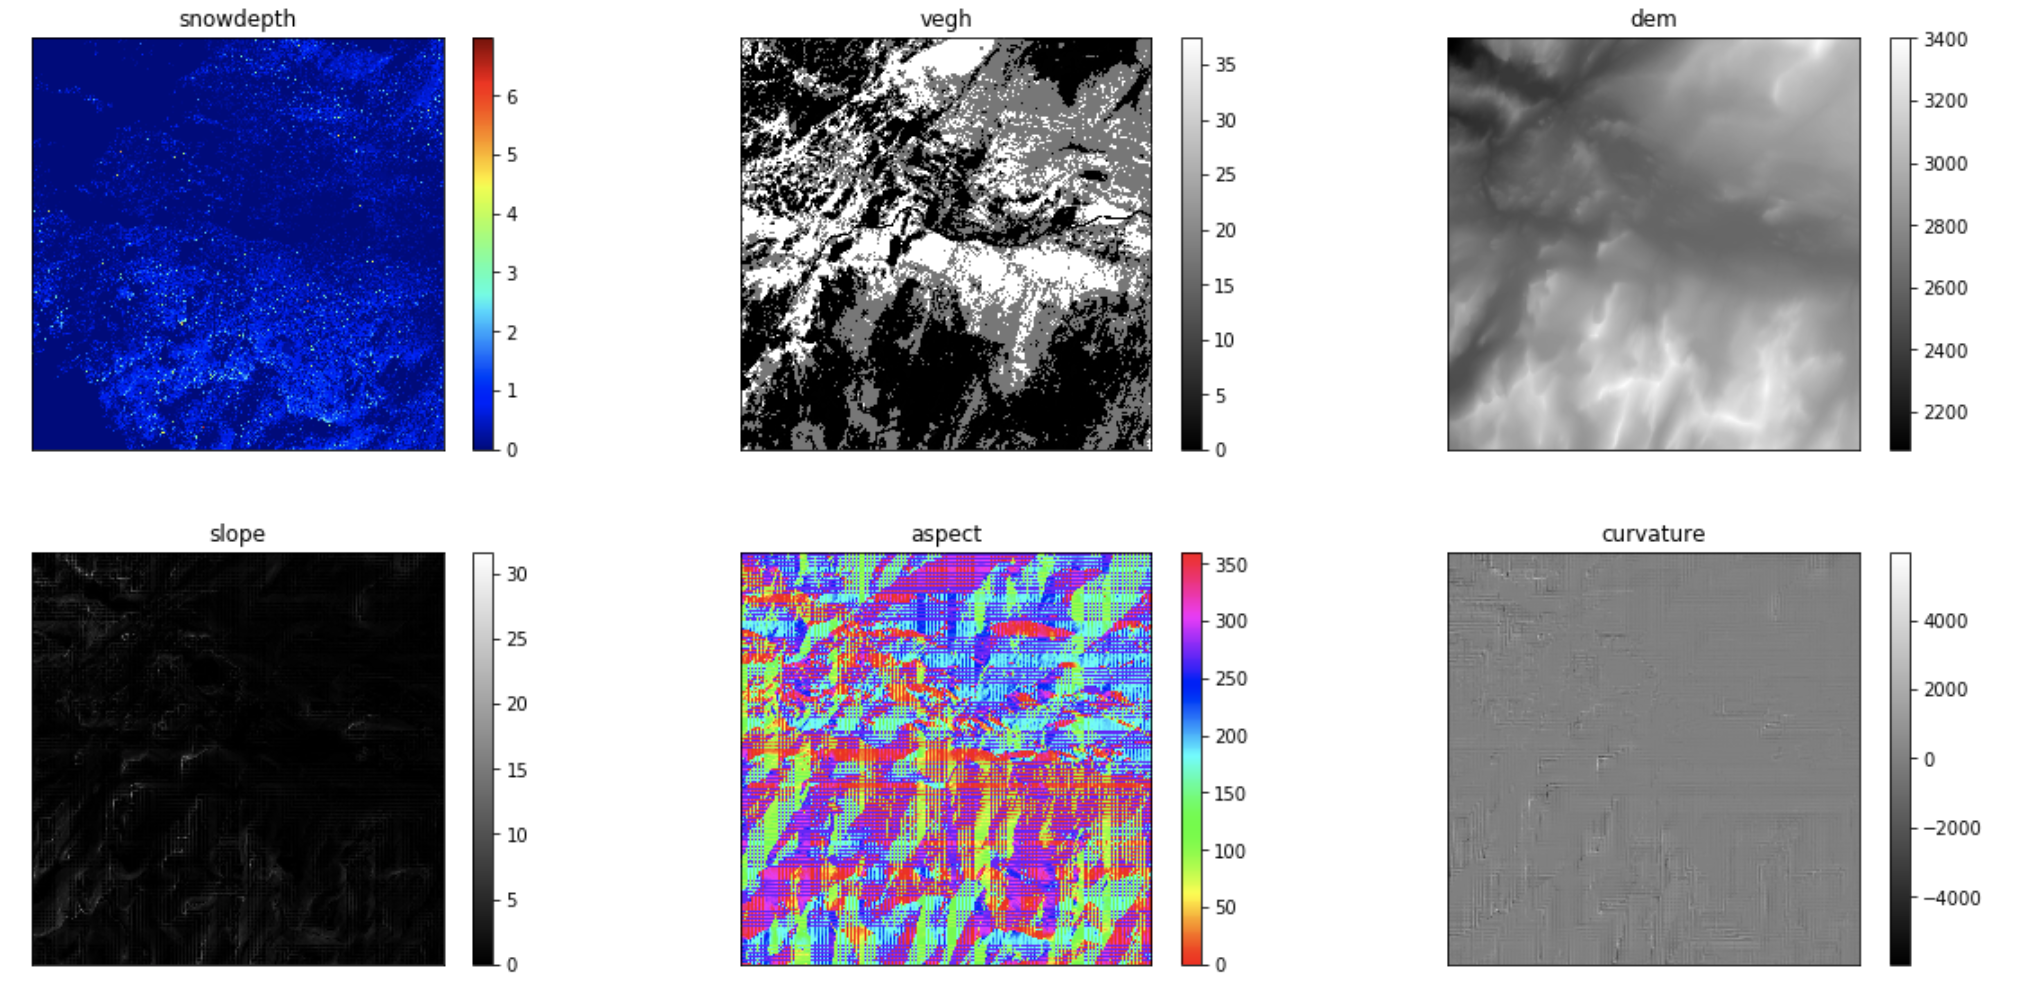

In [9]:
from IPython.display import Image
Image(filename='../../figures/input_output_features.png')

### Import Data

In [3]:
datos = joblib.load('../../processed/subset_datos.joblib')

### Print the Shapes of the arrays found in the dictionary.

In [4]:
for llave, d in datos.items():
    print(llave, datos[llave].shape)

snowdepth (4000, 4000)
vegh (4000, 4000)
dem (4000, 4000)
slope (4000, 4000)
aspect (4000, 4000)
curvature (4000, 4000)


## Generate the X and Y for Keras:
```
1. stack all of the items in the dictionary datos
2. expand the dimension of Y 
3. Deine Size, Stride and Window the data.
4. Stack the images to have a shape of (no_samples, nrows, ncols, nfeatures)
```

In [5]:
X = np.stack([d for llave, d in datos.items() if llave != 'snowdepth'], axis=-1)
Y = np.expand_dims(datos['snowdepth'], axis=-1)

kernal = (50, 50)
stride = (50, 50)
XX = ventana(signal=X, kernel_size=kernal, stride=stride)
YY = ventana(signal=Y, kernel_size=kernal, stride=stride)

XX = np.stack(XX, axis=0)
YY = np.stack(YY, axis=0)

print(XX.shape)
print(YY.shape)

(6400, 50, 50, 5)
(6400, 50, 50, 1)


## Create Training and Testing Sets
```
1. Define the percentage of Training
2. Randomly partition X and Y
3. Scale Train and Test sets using parameters from the TRAINING SET
3. Save as dictionary under Xout and Yout => keys: 'train', 'test'
```

In [6]:
Xout = {}
Yout = {}
# UTMEout = {}
# UTMNout = {}
ixs = {}
train_per = .20
# Permuter ---------------------------
train_size = np.int(np.ceil(train_per * XX.shape[0]))
permutation = np.random.permutation(XX.shape[0])
ixs['train'] = np.sort(permutation[:train_size])
ixs['test'] = np.sort(permutation[train_size:])

# Trainset ------------------------
Xout['train'] = XX[ixs['train'], :, :, :]
Yout['train'] = YY[ixs['train'], :, :, :]
# UTMEout['train'] = UTME[ixs['train'], :, :, :]
# UTMNout['train'] = UTMN[ixs['train'], :, :, :]

# Testset -------------------------
Xout['test'] = XX[ixs['test'], :, :, :]
Yout['test'] = YY[ixs['test'], :, :, :]

# UTMEout['test'] = UTME[ixs['test'], :, :, :]
# UTMNout['test'] = UTMN[ixs['test'], :, :, :]

# Scale ------------------
scaler = StandardScaler()
Xtr_tmp = scaler.fit_transform(Xout['train'].reshape(-1, XX.shape[-1]))
Xout['train'] = Xtr_tmp.reshape(Xout['train'].shape)
Xte_tmp = scaler.transform(Xout['test'].reshape(-1, XX.shape[-1]))
Xout['test'] = Xte_tmp.reshape(Xout['test'].shape)

## Print the Shapes of Training and Testing Sets

In [7]:
print('Xtrain:', Xout['train'].shape)
print('Ytrain:', Yout['train'].shape)
print('---')
print('Xtest:', Xout['test'].shape)
print('Ytest:', Yout['test'].shape)

Xtrain: (1280, 50, 50, 5)
Ytrain: (1280, 50, 50, 1)
---
Xtest: (5120, 50, 50, 5)
Ytest: (5120, 50, 50, 1)


### Load the Model Weights and Architechtures

In [8]:
# load json and create model
json_file = open(f'../../models/model_{ARCH}_architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(f'../../models/model_{ARCH}_weights.h5')
print("Loaded model from disk")

W0913 20:40:58.663823 139936514455360 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



ValueError: Unknown initializer: GlorotUniform

### Model Assessment
```
1. Predict on Test and Train
2. Make all predicted snowdepths < 0 to 0. 
```

In [32]:
Ycal = {}
Ycal['test'] = model.predict(Xout['test']).flatten()
Ycal['test'][Ycal['test'] < 0] = 0
Ycal['train'] = model.predict(Xout['train']).flatten()
Ycal['train'][Ycal['train'] < 0] = 0


ValueError: Error when checking input: expected conv2d_11_input to have shape (100, 100, 5) but got array with shape (50, 50, 5)

### Define the Limits to the Scatter Plot

In [29]:
plot_lims = [np.array([Ycal['test'].min(), Ycal['train'].min(), Yout['train'].min(), Yout['test'].min()]).min(),
            np.array([Ycal['test'].max(), Ycal['train'].max(), Yout['train'].max(), Yout['test'].max()]).max()]

In [33]:

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

# Subplot 1 ----------------
ax1.plot(
    Yout['train'].flatten(),
    Ycal['train'].flatten(),
    '.'
)
ax1.set_aspect('equal')
ax1.title.set_text('Train Set')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.ylim(plot_lims)
plt.xlim(plot_lims)

# Subplot 2 ----------------
ax2.plot(
    Yout['test'].flatten(),
    Ycal['test'].flatten(),
    '.'
)
ax2.title.set_text('Hold Out Set')
ax2.set_aspect('equal')
plt.subplots_adjust(wspace=1, hspace=0.15)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.ylim(plot_lims)
plt.xlim(plot_lims)

# Rsquared Values ----------------
plt.savefig('../figures/{0}_obs_vs_pred.png'.format(SITENAME))

In [28]:
print('Train R^2: {0:0.4f}'.format(metrics.r2_score(Yout['train'].flatten(), Ycal['train'].flatten())))
print('Test R^2: {0:.4f}\n'.format(metrics.r2_score(Yout['test'].flatten(), Ycal['test'].flatten())))
# Pearson Correlations -----------------
print('----------------------')
print('Train PearsonCorr: {0:0.2f}'.format(pearsonr(Yout['train'].flatten(), Ycal['train'].flatten())[0]))
print('Test PearsonCorr: {0:.2f}\n'.format(pearsonr(Yout['test'].flatten(), Ycal['test'].flatten())[0]))
print('----------------------')
print(
    'Train RMSE: {0:0.2f}'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['train'].flatten(), Yout['train'].flatten()
            )
        )
    )
)
print(
    'Test RMSE: {0:.2f}\n'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['test'].flatten(), Yout['test'].flatten()
            )
        )
    )
)

Train R^2: 0.3352
Test R^2: 0.2748

----------------------
Train PearsonCorr: 0.58
Test PearsonCorr: 0.53

----------------------
Train RMSE: 0.32
Test RMSE: 0.34

